In [1]:
import sys
sys.path.append("../")

from src.analysis.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')

DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-02-02'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
def load_and_prepare_data(file_path):

    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 100
Total trading days: 1022


Analyzing pairs: 100%|██████████| 4950/4950 [01:03<00:00, 78.13it/s]



Analysis complete!
Found 330 cointegrated pairs
Total pairs analyzed: 4950


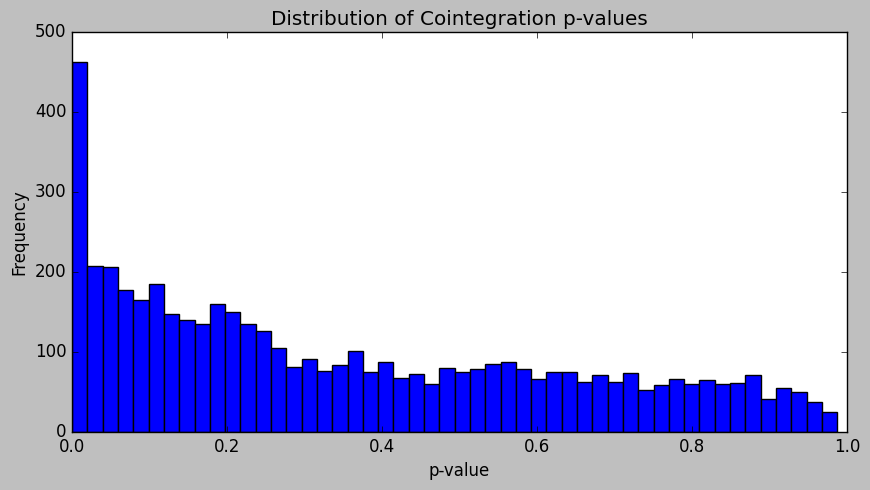

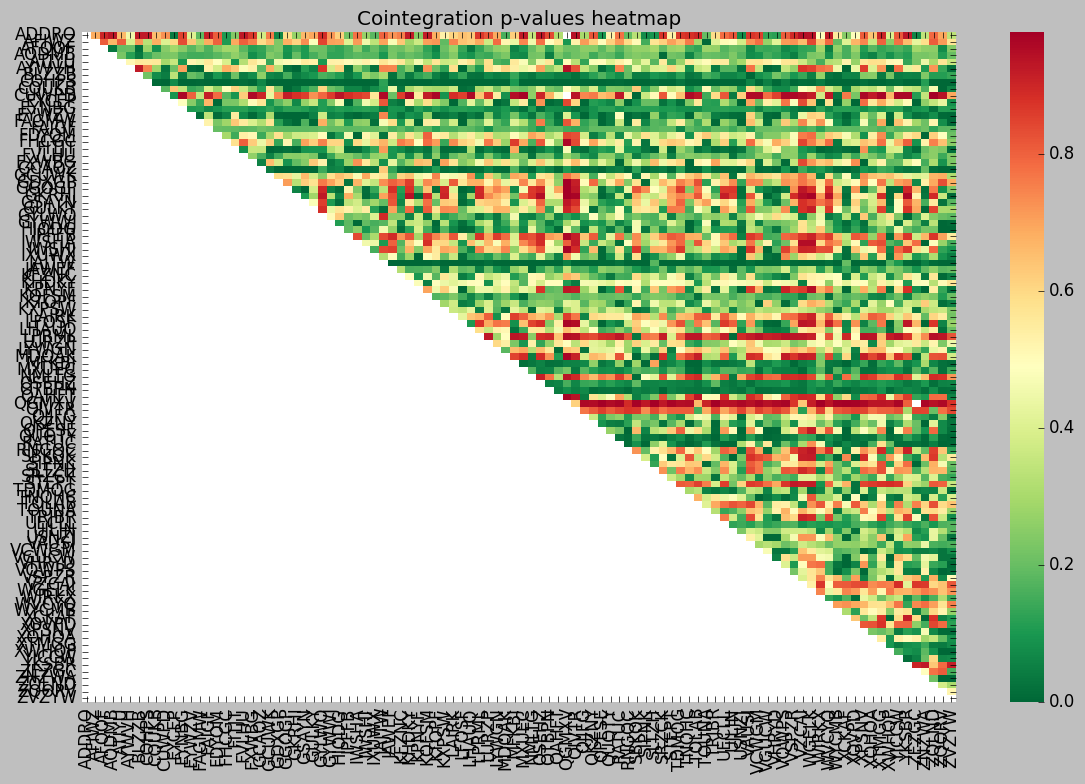

In [3]:
price_matrix, symbols = load_and_prepare_data('./sim_daily.parquet')

score_matrix, pvalue_matrix, pairs, summary_df = analyze_pairs(
    price_matrix,
    pvalue_threshold=0.01
)

plt.figure(figsize=(10, 5))
plt.hist(summary_df['p_value'], bins=50)
plt.title('Distribution of Cointegration p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

plot_cointegration_heatmap(pvalue_matrix, symbols)

In [4]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def calculate_spread(data, symbol1, symbol2, start_date=None, end_date=None):
    if start_date:
        mask = (data.index >= start_date) & (data.index <= end_date)
        data = data[mask]
    
    ratios = data[symbol1] / data[symbol2]
    zscore_ratios = zscore(ratios)
    
    return ratios, zscore_ratios

def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, window=50, std_dev=1.5):
    model = sm.OLS(S1_train, S2_train)
    hedge_ratio = model.fit().params[0]
    
    spread_test = S1_test - (S2_test * hedge_ratio)
    
    trades = []
    trade_id = 0
    position = 0
    entry_prices = None
    entry_date = None
    
    prev_spread = None
    
    for i in range(len(spread_test)):
        current_date = spread_test.index[i]
        current_spread = spread_test.iloc[i]
        
        rolling_mean = spread_test.iloc[:i+1].rolling(window=window, center=False).mean().iloc[-1]
        rolling_std = spread_test.iloc[:i+1].rolling(window=window, center=False).std().iloc[-1]
        
        upper_band = rolling_mean + (rolling_std * std_dev)
        lower_band = rolling_mean - (rolling_std * std_dev)
        
        if prev_spread is not None:
            if position == 0:
                if prev_spread > lower_band and current_spread < lower_band:
                    entry_date = current_date
                    entry_prices = {
                        symbol1: {"price": S1_test.iloc[i], "type": "long"},
                        symbol2: {"price": S2_test.iloc[i], "type": "short"}
                    }
                    position = 1
                    
                elif prev_spread < upper_band and current_spread > upper_band:
                    entry_date = current_date
                    entry_prices = {
                        symbol1: {"price": S1_test.iloc[i], "type": "short"},
                        symbol2: {"price": S2_test.iloc[i], "type": "long"}
                    }
                    position = -1
                    
            elif ((position == 1 and prev_spread < upper_band and current_spread > upper_band) or 
                  (position == -1 and prev_spread > lower_band and current_spread < lower_band)):
                
                for symbol in [symbol1, symbol2]:
                    trades.append({
                        'trade_id': trade_id,
                        'symbol': symbol,
                        'entry_date': entry_date,
                        'entry_price': entry_prices[symbol]["price"],
                        'exit_date': current_date,
                        'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                        'position_type': entry_prices[symbol]["type"],
                        'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                        'exit_type': 'target'
                    })
                position = 0
                trade_id += 1
                
        prev_spread = current_spread
            
    return trades

def backtest_pairs(price_matrix, pairs, train_end_date):
    all_trades = []
    
    for symbol1, symbol2 in pairs:
        training_mask = price_matrix.index < train_end_date
        
        S1_train = price_matrix[symbol1][training_mask]
        S2_train = price_matrix[symbol2][training_mask]
        S1_test = price_matrix[symbol1][~training_mask]
        S2_test = price_matrix[symbol2][~training_mask]
        
        pair_trades = trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2)
        all_trades.extend(pair_trades)
    
    trades_df = pd.DataFrame(all_trades)
    trades_df.to_parquet('./results/coint_bollinger_results.parquet')
    
    return trades_df

In [5]:
trades_df = backtest_pairs(price_matrix, pairs, DATE_CONFIG['TRAIN_END'])